<a href="https://colab.research.google.com/github/gerald-liu/credit-card-default-prediction/blob/master/Model6_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Import basic libraries
import numpy as np 
import pandas as pd
import joblib # for saving models

In [0]:
# Create lists for relevant numerical features
repayments = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
bill_amounts = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
payments = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [0]:
# Load data from GitHub
data_url = 'https://raw.githubusercontent.com/gerald-liu/credit-card-default-prediction/master/data/data.csv?token=AIUUIXO7TWYXTCZ3XJ6SAEK6YVR5W'
data = pd.read_csv(data_url, index_col = 'ID')

In [0]:
data = data.rename(columns={'default.payment.next.month': 'def_pay', 'PAY_0': 'PAY_1'})

In [0]:
mask_edu_good=data['EDUCATION'].isin(range(1,5))
data['EDUCATION'].mask(~mask_edu_good,data['EDUCATION'][mask_edu_good].sample(n=(~mask_edu_good).sum(),replace=True).tolist(),inplace=True)

data['EDUCATION'].value_counts()

2    14179
1    10722
3     4975
4      124
Name: EDUCATION, dtype: int64

In [0]:
mask_marriage_good=data['MARRIAGE'].isin(range(1,4))
data['MARRIAGE'].mask(~mask_marriage_good,data['MARRIAGE'][mask_marriage_good].sample(n=(~mask_marriage_good).sum(),replace=True).tolist(),inplace=True)

data['MARRIAGE'].value_counts()

2    15992
1    13685
3      323
Name: MARRIAGE, dtype: int64

In [0]:
# final check
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LIMIT_BAL  30000 non-null  float64
 1   SEX        30000 non-null  int64  
 2   EDUCATION  30000 non-null  int64  
 3   MARRIAGE   30000 non-null  int64  
 4   AGE        30000 non-null  int64  
 5   PAY_1      30000 non-null  int64  
 6   PAY_2      30000 non-null  int64  
 7   PAY_3      30000 non-null  int64  
 8   PAY_4      30000 non-null  int64  
 9   PAY_5      30000 non-null  int64  
 10  PAY_6      30000 non-null  int64  
 11  BILL_AMT1  30000 non-null  float64
 12  BILL_AMT2  30000 non-null  float64
 13  BILL_AMT3  30000 non-null  float64
 14  BILL_AMT4  30000 non-null  float64
 15  BILL_AMT5  30000 non-null  float64
 16  BILL_AMT6  30000 non-null  float64
 17  PAY_AMT1   30000 non-null  float64
 18  PAY_AMT2   30000 non-null  float64
 19  PAY_AMT3   30000 non-null  float64
 20  PAY_AM

In [0]:
# export to csv
# data.to_csv('data/data_clean.csv')

In [0]:
# from google.colab import files
# files.download('data/data_clean.csv')

## Data preprocessing

In [0]:
# load clean data from GitHub
data_clean_url = 'https://raw.githubusercontent.com/gerald-liu/credit-card-default-prediction/master/data/data_clean.csv?token=AIUUIXMO7222YRXRNZ5KSG26YVS22'
data = pd.read_csv(data_clean_url, index_col = 'ID')

In [0]:
# binning of age
# num_age_groups = 3
# data['AGE_BINNED']=pd.cut(data['AGE'], num_age_groups, labels=range(1, num_age_groups+1))

In [7]:
# data['AGE_BINNED'].value_counts()

1    21726
2     7935
3      339
Name: AGE_BINNED, dtype: int64

In [0]:
to_transform = ['LIMIT_BAL'] + bill_amounts + payments

In [0]:
from sklearn.preprocessing import PowerTransformer

In [0]:
pt = PowerTransformer()
data[to_transform] = pt.fit_transform(data[to_transform])

In [0]:
# data.to_csv('data/data_normalized.csv')

In [0]:
# from google.colab import files
# files.download('data/data_normalized.csv')

## Ensemble Methods

In [0]:
# load normalized data from GitHub
data_normalized_url = 'https://raw.githubusercontent.com/gerald-liu/credit-card-default-prediction/master/data/data_normalized.csv?token=AIUUIXMEODJ5KTREUL32HNK6YYBRO'
data = pd.read_csv(data_normalized_url, index_col = 'ID')

In [4]:
data.describe().round(4)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,def_pay
count,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000
mean,0.0000,1.6037,1.8167,1.5546,35.4855,-0.0167,-0.1338,-0.1662,-0.2207,-0.2662,-0.2911,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.2212
std,1.0000,0.4891,0.7115,0.5182,9.2179,1.1238,1.1972,1.1969,1.1691,1.1332,1.1500,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.4151
min,-2.0989,1.0000,1.0000,1.0000,21.0000,-2.0000,-2.0000,-2.0000,-2.0000,-2.0000,-2.0000,-41.4910,-34.4043,-52.4104,-49.3123,-35.6684,-48.3908,-1.7245,-1.7054,-1.6300,-1.5781,-1.5570,-1.5158,0.0000
25%,-0.9539,1.0000,1.0000,1.0000,28.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-0.6617,-0.6697,-0.6556,-0.6458,-0.6483,-0.6240,-0.2443,-0.2753,-0.4242,-0.4215,-0.4574,-0.6170,0.0000
50%,0.0837,2.0000,2.0000,2.0000,34.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.3436,-0.3281,-0.3338,-0.3209,-0.2971,-0.3162,0.0870,0.1006,0.1675,0.1739,0.1820,0.2151,0.0000
75%,0.7521,2.0000,2.0000,2.0000,41.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2927,0.3133,0.2770,0.2558,0.2615,0.2293,0.5489,0.5680,0.6127,0.6253,0.6311,0.6363,0.0000
max,3.0658,2.0000,4.0000,3.0000,79.0000,8.0000,8.0000,8.0000,8.0000,8.0000,8.0000,9.7490,9.6391,16.5508,10.1698,10.6786,12.3746,6.0774,6.8291,5.3782,4.6289,4.1556,4.0342,1.0000


In [0]:
X = data.drop('def_pay', axis=1)
y = data['def_pay']

In [0]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split

### Random Forest

In [18]:
rf = RandomForestClassifier()
rf.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
# joblib.dump(rf, 'models/rf.joblib')
# files.download('models/rf.joblib')

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def plot_feature_importances(model, feature_names):
    feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': model.feature_importances_})
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

    plt.title('Feature Importances')
    s = sns.barplot(x='Feature', y='Importance', data=feature_importances)
    s.set_xticklabels(s.get_xticklabels(), rotation=90)
    plt.show()

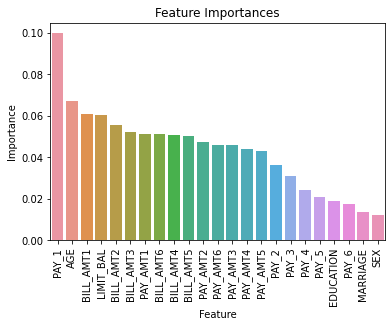

In [44]:
plot_feature_importances(rf, X.columns)

In [0]:
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [0]:
y_pred = cross_val_predict(rf, X, y, cv=10)

In [31]:
cross_val_score(rf, X, y, cv=10).mean()

0.8164000000000001

In [0]:
def eval_confusion_matrix(y, y_pred):
    cmat = confusion_matrix(y, y_pred)
    print("Confusion Matrix:", "\n", confusion_matrix(y, y_pred))
    print('TP - True Negative {}'.format(cmat[0,0]))
    print('FP - False Positive {}'.format(cmat[0,1]))
    print('FN - False Negative {}'.format(cmat[1,0]))
    print('TN - True Negative {}'.format(cmat[1,1]))
    print("\nClassification Report:","\n", classification_report(y, y_pred, zero_division=0))
    print('Accuracy Rate: {}'.format(np.divide(np.sum([cmat[0,0],cmat[1,1]]),np.sum(cmat))))
    print('Misclassification Rate: {}'.format(np.divide(np.sum([cmat[0,1],cmat[1,0]]),np.sum(cmat))))

In [33]:
eval_confusion_matrix(y, y_pred)

Confusion Matrix: 
 [[22020  1344]
 [ 4181  2455]]
TP - True Negative 22020
FP - False Positive 1344
FN - False Negative 4181
TN - True Negative 2455

Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.94      0.89     23364
           1       0.65      0.37      0.47      6636

    accuracy                           0.82     30000
   macro avg       0.74      0.66      0.68     30000
weighted avg       0.80      0.82      0.80     30000

Accuracy Rate: 0.8158333333333333
Misclassification Rate: 0.18416666666666667


In [0]:
y_pred_proba = cross_val_predict(rf, X, y, cv=10, method= 'predict_proba')

In [35]:
fpr, tpr, thresholds = roc_curve(y, y_pred_proba[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

roc_auc

0.764498037273461

### AdaBoost

In [49]:
ab = AdaBoostClassifier()
ab.fit(X, y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [0]:
joblib.dump(ab, 'models/ab.joblib')
files.download('models/ab.joblib')

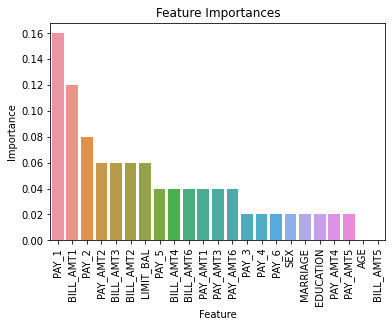

In [51]:
plot_feature_importances(ab, X.columns)

In [52]:
y_pred = cross_val_predict(ab, X, y, cv=10)
cross_val_score(ab, X, y, cv=10).mean()

0.8163

In [53]:
eval_confusion_matrix(y, y_pred)

Confusion Matrix: 
 [[22361  1003]
 [ 4508  2128]]
TP - True Negative 22361
FP - False Positive 1003
FN - False Negative 4508
TN - True Negative 2128

Classification Report: 
               precision    recall  f1-score   support

           0       0.83      0.96      0.89     23364
           1       0.68      0.32      0.44      6636

    accuracy                           0.82     30000
   macro avg       0.76      0.64      0.66     30000
weighted avg       0.80      0.82      0.79     30000

Accuracy Rate: 0.8163
Misclassification Rate: 0.1837


In [54]:
y_pred_proba = cross_val_predict(ab, X, y, cv=10, method= 'predict_proba')
fpr, tpr, thresholds = roc_curve(y, y_pred_proba[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

roc_auc

0.7714415400467214

### Gradient Boosting

#### scikit-learn

In [0]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X, y)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [0]:
# joblib.dump(gb, 'models/gb.joblib')
# files.download('models/gb.joblib')

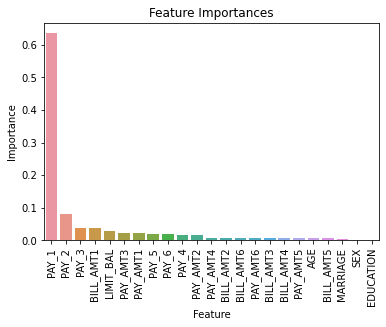

In [0]:
plot_feature_importances(gb, X.columns)

In [0]:
y_pred = cross_val_predict(xgb_1, X, y, cv=10)
cross_val_score(gb, X, y, cv=10).mean()

In [0]:
eval_confusion_matrix(y, y_pred)

Confusion Matrix: 
 [[22191  1173]
 [ 4203  2433]]
TP - True Negative 22191
FP - False Positive 1173
FN - False Negative 4203
TN - True Negative 2433

Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.95      0.89     23364
           1       0.67      0.37      0.48      6636

    accuracy                           0.82     30000
   macro avg       0.76      0.66      0.68     30000
weighted avg       0.80      0.82      0.80     30000

Accuracy Rate: 0.8208
Misclassification Rate: 0.1792


In [0]:
y_pred_proba = cross_val_predict(gb, X, y, cv=10, method= 'predict_proba')
fpr, tpr, thresholds = roc_curve(y, y_pred_proba[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

roc_auc

0.7800866329749616

#### CatBoost

In [0]:
catb_params = {
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'logging_level': 'Silent',
    'random_seed': 42
}

In [87]:
catb_1 = CatBoostClassifier(**catb_params)
catb_1.fit(X, y)

In [0]:
joblib.dump(catb_1, 'models/catb.joblib')
files.download('models/catb.joblib')

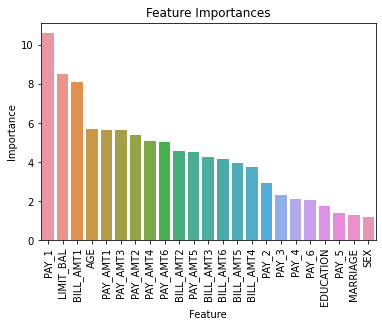

In [89]:
plot_feature_importances(catb_1, X.columns)

In [0]:
y_pred = cross_val_predict(catb_1, X, y, cv=10)

In [91]:
eval_confusion_matrix(y, y_pred)

Confusion Matrix: 
 [[22129  1235]
 [ 4185  2451]]
TP - True Negative 22129
FP - False Positive 1235
FN - False Negative 4185
TN - True Negative 2451

Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.95      0.89     23364
           1       0.66      0.37      0.47      6636

    accuracy                           0.82     30000
   macro avg       0.75      0.66      0.68     30000
weighted avg       0.80      0.82      0.80     30000

Accuracy Rate: 0.8193333333333334
Misclassification Rate: 0.18066666666666667


In [92]:
y_pred_proba = cross_val_predict(catb_1, X, y, cv=10, method= 'predict_proba')
fpr, tpr, thresholds = roc_curve(y, y_pred_proba[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

roc_auc

0.7806429865000987

#### XGBoost

In [0]:
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'silent': True,
    'seed': 42
}

In [40]:
xgb_1 = XGBClassifier(**xgb_params)
xgb_1.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=True, subsample=1, verbosity=1)

In [0]:
joblib.dump(xgb_1, 'models/xgb.joblib')
files.download('models/xgb.joblib')

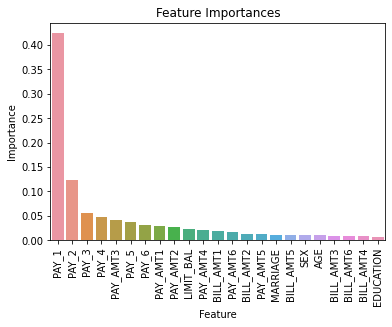

In [41]:
plot_feature_importances(xgb_1, X.columns)

In [0]:
y_pred = cross_val_predict(xgb_1, X, y, cv=10)
# cross_val_score(xgb_1, X, y, cv=10, scoring='accuracy').mean()

In [43]:
eval_confusion_matrix(y, y_pred)

Confusion Matrix: 
 [[22220  1144]
 [ 4215  2421]]
TP - True Negative 22220
FP - False Positive 1144
FN - False Negative 4215
TN - True Negative 2421

Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.95      0.89     23364
           1       0.68      0.36      0.47      6636

    accuracy                           0.82     30000
   macro avg       0.76      0.66      0.68     30000
weighted avg       0.80      0.82      0.80     30000

Accuracy Rate: 0.8213666666666667
Misclassification Rate: 0.17863333333333334


In [44]:
y_pred_proba = cross_val_predict(xgb_1, X, y, cv=10, method= 'predict_proba')
fpr, tpr, thresholds = roc_curve(y, y_pred_proba[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

roc_auc

0.7804951279996871

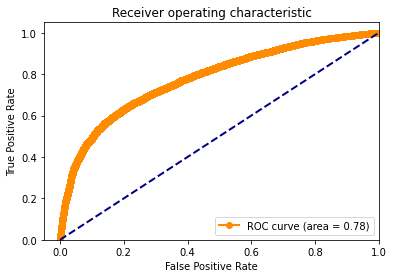

In [45]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, marker='o',color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

##### Parameter tuning

In [0]:
xgb_trial_grid = {
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [3, 6, 9],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1]
}

In [0]:
from sklearn.model_selection import GridSearchCV

In [0]:
xgb_grid = GridSearchCV(XGBClassifier(**xgb_params),
                        param_grid=xgb_trial_grid,
                        cv=10,
                        n_jobs=-1,
                        verbose=1)

In [22]:
xgb_grid.fit(X, y)

Fitting 10 folds for each of 81 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 30.7min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 45.3min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed: 58.9min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, eval_metric='auc',
                                     gamma=0, learning_rate=0.1,
                                     max_delta_step=0, max_depth=3,
                                     min_child_weight=1, missing=None,
                                     n_estimators=100, n_jobs=1, nthread=None,
                                     objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=42, silent=True,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9, 1],
                         'learning_rate': [0.05, 0.1, 0.15],
   

In [23]:
xgb_grid.best_params_

{'colsample_bytree': 0.9,
 'learning_rate': 0.05,
 'max_depth': 3,
 'subsample': 0.8}

In [24]:
xgb_grid.best_score_

0.8217666666666666

In [25]:
xgb_best = xgb_grid.best_estimator_

joblib.dump(xgb_best, 'models/xgb_best.joblib')

['models/xgb_best.joblib']

In [0]:
files.download('models/xgb_best.joblib')

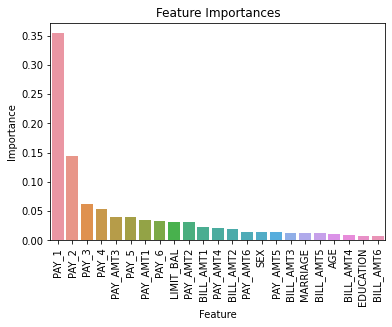

In [35]:
plot_feature_importances(xgb_best, X.columns)

In [0]:
y_pred = cross_val_predict(xgb_best, X, y, cv=10)

In [37]:
eval_confusion_matrix(y, y_pred)

Confusion Matrix: 
 [[22257  1107]
 [ 4240  2396]]
TP - True Negative 22257
FP - False Positive 1107
FN - False Negative 4240
TN - True Negative 2396

Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.95      0.89     23364
           1       0.68      0.36      0.47      6636

    accuracy                           0.82     30000
   macro avg       0.76      0.66      0.68     30000
weighted avg       0.81      0.82      0.80     30000

Accuracy Rate: 0.8217666666666666
Misclassification Rate: 0.17823333333333333


In [38]:
y_pred_proba = cross_val_predict(xgb_best, X, y, cv=10, method= 'predict_proba')
fpr, tpr, thresholds = roc_curve(y, y_pred_proba[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

roc_auc

0.777598215272534

#### LightGBM

In [0]:
lgbm_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'seed': 42
}

In [69]:
lgbm_1 = LGBMClassifier(**lgbm_params)
lgbm_1.fit(X, y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               metric='auc', min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective='binary', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, seed=42, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [0]:
joblib.dump(lgbm_1, 'models/lgbm.joblib')
# files.download('models/lgbm.joblib')

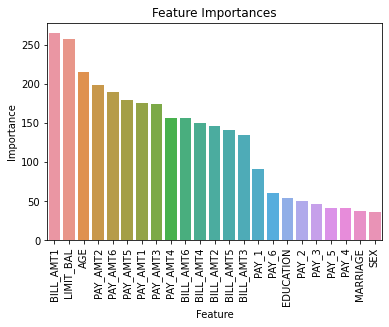

In [72]:
plot_feature_importances(lgbm_1, X.columns)

In [0]:
y_pred = cross_val_predict(lgbm_1, X, y, cv=10)

In [74]:
eval_confusion_matrix(y, y_pred)

Confusion Matrix: 
 [[22171  1193]
 [ 4170  2466]]
TP - True Negative 22171
FP - False Positive 1193
FN - False Negative 4170
TN - True Negative 2466

Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.95      0.89     23364
           1       0.67      0.37      0.48      6636

    accuracy                           0.82     30000
   macro avg       0.76      0.66      0.69     30000
weighted avg       0.80      0.82      0.80     30000

Accuracy Rate: 0.8212333333333334
Misclassification Rate: 0.17876666666666666


In [75]:
y_pred_proba = cross_val_predict(lgbm_1, X, y, cv=10, method= 'predict_proba')
fpr, tpr, thresholds = roc_curve(y, y_pred_proba[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

roc_auc

0.7799695206836915